In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import qutip

import sys; sys.path.append("../../../Archive/Research/INQNET/superdense")
import squanch


from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD, Adam

K.set_floatx('float64')

from qpga import *

Using TensorFlow backend.


In [2]:
def build_model(N, depth):
    layers = [SingleQubitOperationLayer(N)]
    for i in range(depth):
        layers.append(CPhaseLayer(N, parity=i%2))
        layers.append(SingleQubitOperationLayer(N))

    return Sequential(layers)

## Preparing NOON state with limited coupling strengths

In [8]:
N = 8
num_samples = 1000

in_data = np_to_k_complex(np.array([zero_state(N)] * num_samples))
out_data = np_to_k_complex(np.array([noon_state(N)] * num_samples))

In [9]:
model = QPGA(N, 5*N).as_sequential()
model.compile(optimizer=Adam(lr=0.01), 
              loss=antifidelity, 
              metrics=[antifidelity, 'mse'])

callback = FrameWriterCallback(input_state = in_data[0:1], target_state = out_data[0:1])

history = model.fit(in_data, out_data, epochs=3, batch_size=10, callbacks=[callback])

Epoch 1/3
1000/1000 [==============================] - 169s 169ms/step - loss: 0.1401 - antifidelity: 0.1401 - mean_squared_error: 0.0069
Epoch 2/3
1000/1000 [==============================] - 102s 102ms/step - loss: 0.0037 - antifidelity: 0.0037 - mean_squared_error: 0.0077
Epoch 3/3
1000/1000 [==============================] - 105s 105ms/step - loss: 0.0020 - antifidelity: 0.0020 - mean_squared_error: 0.0072


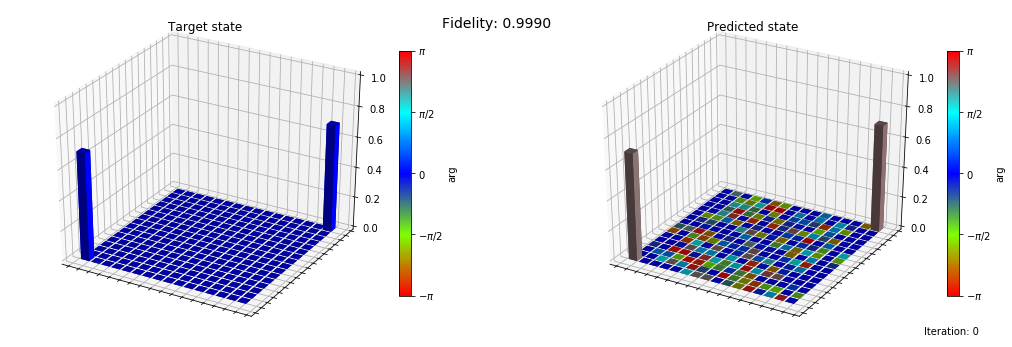

In [10]:
# plot_state_comparison(out_data[0:1], callback.predictions[-1], iteration=0, savefig=False)
plot_state_comparison(out_data[0:1], model.predict(in_data[0:1]), iteration=0)

In [18]:
outputs = model.call(in_data[0:10])
outputs

<tf.Tensor 'single_qubit_operation_layer_164_4/stack:0' shape=(10, 2, 256) dtype=float64>

In [20]:
1 - outputs

<tf.Tensor 'sub:0' shape=(10, 2, 256) dtype=float64>

## Implementing QFT

In [9]:
def QFT(qubits):
    '''Applies quantum Fourier transform to inputs'''
    N = len(qubits)
    for n in range(N, 0, -1):
        target = qubits[N - n]
        squanch.H(target)
        for m in range(1, n):
            squanch.CPHASE(qubits[N - n + m], target,2*np.pi/2**(m+1))

In [17]:
N = 5
states = np.array([get_random_state_vector(N) for _ in range(10000)])
states[0] = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)

qstream = squanch.QStream.from_array(np.copy(states), use_density_matrix=False)
for qsys in qstream:
    QFT(list(qsys.qubits))

out_states = np.copy(qstream.state)

in_data = np_to_k_complex(states)
out_data = np_to_k_complex(out_states)

In [18]:
learning_rate = 0.001 # 2**N * 0.001
opt = Adam(lr=learning_rate)
    
model = build_model(N, 4*N)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
history = model.fit(in_data, out_data, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 2/10
10000/10000 [==============================] - 10s 968us/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 3/10
10000/10000 [==============================] - 10s 984us/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 4/10
10000/10000 [==============================] - 10s 975us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/10
10000/10000 [==============================] - 10s 985us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 6/10
10000/10000 [==============================] - 10s 967us/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 7/10
10000/10000 [==============================] - 10s 987us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 8/10
10000/10000 [==============================] - 10s 982us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 9/10
10000/10000 [==============================] - 10s 975u

## NOON state preparation

In [10]:
N = 8
num_samples = 10000

in_state = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)
out_state = 1/np.sqrt(2) * np.array([1]  + [0] * (2**N - 2) + [1], dtype=np.complex128)

in_data = np_to_k_complex(np.array([in_state] * num_samples))
out_data = np_to_k_complex(np.array([out_state] * num_samples))

In [6]:
def plot_state_comparison(true_state, pred_state, iteration=None, savefig=False):
    true_state = np_to_complex(true_state)[0]
    pred_state = np_to_complex(pred_state)[0]
    fidelity = np.abs(np.dot(true_state.conj(), pred_state))**2
    mat_true = reshape_state_vector(true_state)
    mat_pred = reshape_state_vector(pred_state)
    fig = plt.figure(figsize = (18,6))
#     fig.text(.5, .8, "Fidelity: $\left<\psi_\mathrm\{{true}} | \psi_\mathrm\{{pred}} \right>$ = {:.4f}".format(fidelity))
    fig.text(.5, .85, "Fidelity: {:.4f}".format(fidelity), fontsize=14, ha='center', va='center')
    if iteration is not None:
        fig.text(.83, .13, "Iteration: {}".format(iteration))
    ax1 = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122,projection='3d')
    qutip.matrix_histogram_complex(mat_true, xlabels=[''], ylabels=[''], title="Target state", fig=fig, ax=ax1)
    qutip.matrix_histogram_complex(mat_pred, xlabels=[''], ylabels=[''], title="Predicted state", fig=fig, ax=ax2)
    if savefig:
        title = str(iteration).zfill(5)
        plt.savefig(f"frames/{title}.png", dpi=144)
        plt.close()
    else:
        plt.show()

In [13]:
learning_rate = 0.01 # 2**N * 0.001
opt = Adam(lr=learning_rate)
    
model1 = build_model(N, 4*N)
model1.compile(optimizer=opt, loss='mse', metrics=['mse'])

callback = FrameWriterCallback()

history = model1.fit(in_data, out_data, epochs=3, batch_size=100, callbacks=[callback])

Epoch 1/3
10000/10000 [==============================] - 166s 17ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/3
10000/10000 [==============================] - 119s 12ms/step - loss: 4.5154e-04 - mean_squared_error: 4.5154e-04
Epoch 3/3
10000/10000 [==============================] - 123s 12ms/step - loss: 2.6562e-04 - mean_squared_error: 2.6562e-04


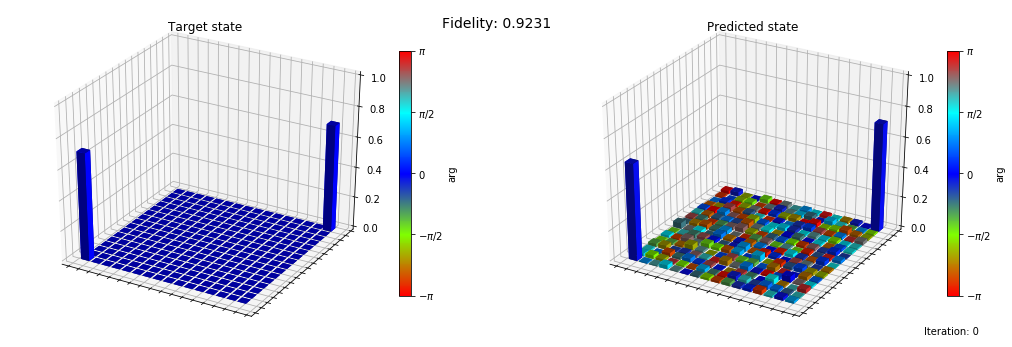

In [14]:
plot_state_comparison(out_data[0:1], model1.predict(in_data[0:1]), iteration=0)

In [15]:
for i, pred_state in enumerate(callback.predictions):
    print("Saving frame {}/{}...".format(i, len(callback.predictions)))
    plot_state_comparison(callback.predict_state, pred_state, iteration=i, savefig=True)

Saving frame 0/300...
Saving frame 1/300...
Saving frame 2/300...
Saving frame 3/300...
Saving frame 4/300...
Saving frame 5/300...
Saving frame 6/300...
Saving frame 7/300...
Saving frame 8/300...
Saving frame 9/300...
Saving frame 10/300...
Saving frame 11/300...
Saving frame 12/300...
Saving frame 13/300...
Saving frame 14/300...
Saving frame 15/300...
Saving frame 16/300...
Saving frame 17/300...
Saving frame 18/300...
Saving frame 19/300...
Saving frame 20/300...
Saving frame 21/300...
Saving frame 22/300...
Saving frame 23/300...
Saving frame 24/300...
Saving frame 25/300...
Saving frame 26/300...
Saving frame 27/300...
Saving frame 28/300...
Saving frame 29/300...
Saving frame 30/300...
Saving frame 31/300...
Saving frame 32/300...
Saving frame 33/300...
Saving frame 34/300...
Saving frame 35/300...
Saving frame 36/300...
Saving frame 37/300...
Saving frame 38/300...
Saving frame 39/300...
Saving frame 40/300...
Saving frame 41/300...
Saving frame 42/300...
Saving frame 43/300..